In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


# HYBRID MODEL

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression


In [ ]:
# Load the dataset
df = pd.read_csv("/content/dataset_2020_2022.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(by='DateTime')
df.dropna(subset=['Temperature (\u00b0C)', 'Humidity', 'Value'], inplace=True)


In [ ]:
# Handle outliers by interpolation
def handle_outliers_time_series(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    if outliers.sum() > 0:
        print(f"Column '{column}' - Number of outliers: {outliers.sum()}")
        # Replace outliers with linear interpolation
        df.loc[outliers, column] = np.nan
        df[column] = df[column].interpolate(method='linear')
        print(f"Outliers in column '{column}' handled by interpolation.")
    else:
        print(f"No outliers found in column '{column}'.")




In [ ]:
# Apply to the 'Value' column
handle_outliers_time_series('Value')


Column 'Value' - Number of outliers: 611
Outliers in column 'Value' handled by interpolation.


In [ ]:
# Function to check for outliers
def check_outliers(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Count outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Column '{column}' - Number of outliers: {len(outliers)}")
    if len(outliers) == 0:
        print(f"No outliers found in column '{column}'.")
    else:
        print(f"Outliers in column '{column}' need further review.")

# Verify outliers for relevant columns
check_outliers('Temperature (\u00b0C)')
check_outliers('Humidity')
check_outliers('Value')

Column 'Temperature (°C)' - Number of outliers: 0
No outliers found in column 'Temperature (°C)'.
Column 'Humidity' - Number of outliers: 0
No outliers found in column 'Humidity'.
Column 'Value' - Number of outliers: 0
No outliers found in column 'Value'.


In [ ]:
# Add temporal features
df['DayOfMonth'] = df['DateTime'].dt.day
df['DayOfWeek'] = df['DateTime'].dt.weekday  # Monday=0, Sunday=6
df['HourOfDay'] = df['DateTime'].dt.hour  # Add the HourOfDay feature
df['Quarter'] = df['DateTime'].dt.quarter
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year
df['DayOfYear'] = df['DateTime'].dt.dayofyear
df['WeekOfYear'] = df['DateTime'].dt.isocalendar().week


In [ ]:
from tabulate import tabulate

# Print the head and tail in tabular format
print("Head of DataFrame:")
print(tabulate(df.head(), headers='keys', tablefmt='pretty', showindex=False))

print("\nTail of DataFrame:")
print(tabulate(df.tail(), headers='keys', tablefmt='pretty', showindex=False))


Head of DataFrame:
+---------------------+------------------+----------+---------+------------+-----------+-----------+---------+-------+------+-----------+------------+
|      DateTime       | Temperature (°C) | Humidity |  Value  | DayOfMonth | DayOfWeek | HourOfDay | Quarter | Month | Year | DayOfYear | WeekOfYear |
+---------------------+------------------+----------+---------+------------+-----------+-----------+---------+-------+------+-----------+------------+
| 2020-01-01 05:30:00 |       3.0        |  100.0   | 2220.45 |     1      |     2     |     5     |    1    |   1   | 2020 |     1     |     1      |
| 2020-01-01 05:35:00 |       3.03       |  99.92   | 2262.12 |     1      |     2     |     5     |    1    |   1   | 2020 |     1     |     1      |
| 2020-01-01 05:40:00 |       3.06       |  99.83   | 2280.51 |     1      |     2     |     5     |    1    |   1   | 2020 |     1     |     1      |
| 2020-01-01 05:45:00 |       3.08       |  99.75   | 2334.05 |     1      

In [ ]:


import pandas as pd

# Calculate the correlation matrix for all features
correlation_matrix = df.corr()

# Print the correlation between each feature and the target 'Value'
print("Correlation with 'Value':")
print(correlation_matrix['Value'].sort_values(ascending=False))

Correlation with 'Value':
Value               1.000000
Temperature (°C)    0.655918
DateTime            0.244023
Year                0.222202
HourOfDay           0.207246
Quarter             0.107321
Month               0.106373
DayOfYear           0.102620
WeekOfYear          0.088655
DayOfMonth         -0.013997
DayOfWeek          -0.065513
Humidity           -0.295011
Name: Value, dtype: float64


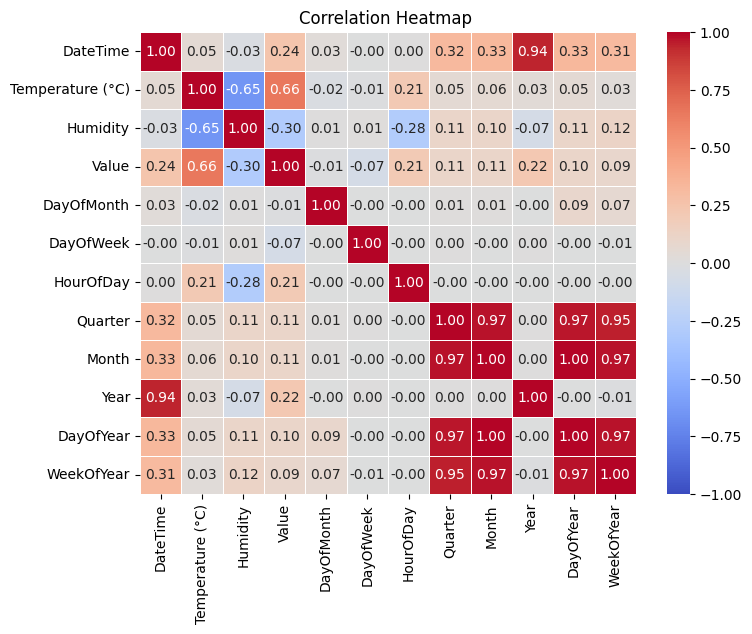

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap ')
plt.show()

In [ ]:
# Split the data into training and testing
train_data = df[df['DateTime'] < '2022-05-30']
test_data = df[df['DateTime'] >= '2022-06-01']

In [ ]:
# Normalize the features and target for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

selected_features = [
    'Temperature (°C)', 'Humidity', 'Year', 'HourOfDay', 'Quarter', 'Month', 'DayOfYear', 'WeekOfYear'
]
train_scaled = train_data.copy()
test_scaled = test_data.copy()
train_scaled[selected_features + ['Value']] = scaler.fit_transform(train_data[selected_features + ['Value']])
test_scaled[selected_features + ['Value']] = scaler.transform(test_data[selected_features + ['Value']])

In [ ]:
# Prepare sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])  # Features (exclude target)
        y.append(data[i + seq_length, -1])  # Target (next value)
    return np.array(X), np.array(y)

In [ ]:
seq_length = 12
features_train = train_scaled[selected_features].values
target_train = train_scaled['Value'].values
features_test = test_scaled[selected_features].values
target_test = test_scaled['Value'].values

In [ ]:
X_train, y_train = create_sequences(np.column_stack([features_train, target_train]), seq_length)
X_test, y_test = create_sequences(np.column_stack([features_test, target_test]), seq_length)

In [ ]:
from tensorflow.keras.regularizers import l2  # Import L2 regularizer

# Define the LSTM model
lstm_model = Sequential()

# Layer 1: LSTM Layer with L2 Regularization
#  - Units: Number of neurons in the LSTM layer (64)
#  - Return sequences: True, because we are adding another LSTM layer
lstm_model.add(LSTM(
    units=64,
    return_sequences=True,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    kernel_regularizer=l2(0.001)  # L2 regularization with strength 0.001
))
# Dropout Layer to reduce overfitting
lstm_model.add(Dropout(0.3))  # Drops 20% of neurons during training

# Layer 2: Second LSTM Layer with L2 Regularization
#  - Units: Number of neurons in the LSTM layer (32)
#  - Return sequences: False, because this is the last LSTM layer
lstm_model.add(LSTM(
    units=32,
    return_sequences=False,
    kernel_regularizer=l2(0.001)  # L2 regularization with strength 0.001
))
# Dropout Layer to reduce overfitting
lstm_model.add(Dropout(0.03))

# Layer 3: Dense Layer (Output Layer) with L2 Regularization
#  - Units: 1, because we are predicting a single value (the target variable)
lstm_model.add(Dense(
    units=1,
    kernel_regularizer=l2(0.001)  # L2 regularization with strength 0.001
))

# Compile the model
#  - Optimizer: Adam (adaptive learning rate optimization)
#  - Loss: Mean Squared Error (used for regression problems)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    epochs=20,  # Number of passes through the dataset
    batch_size=32,  # Reduced batch size for better generalization
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Stops training if validation loss doesn't improve
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 140s 17ms/step - loss: 0.0247 - val_loss: 0.0076
Epoch 2/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - loss: 0.0056 - val_loss: 0.0126
Epoch 3/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 132s 17ms/step - loss: 0.0046 - val_loss: 0.0079
Epoch 4/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 145s 17ms/step - loss: 0.0044 - val_loss: 0.0078
Epoch 5/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 141s 17ms/step - loss: 0.0041 - val_loss: 0.0091
Epoch 6/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 133s 17ms/step - loss: 0.0040 - val_loss: 0.0074
Epoch 7/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 139s 18ms/step - loss: 0.0038 - val_loss: 0.0090
Epoch 8/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 141s 17ms/step - loss: 0.0037 - val_loss: 0.0089
Epoch 9/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - loss: 0.0036 - val_loss: 0.0093
Epoch 10/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - loss: 0.0035 - val_loss: 0.0108
Epoch 11/20
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - loss: 0.0034 - val_loss: 0.01

In [ ]:
# Make predictions with LSTM
lstm_train_predictions = lstm_model.predict(X_train).flatten()
lstm_test_predictions = lstm_model.predict(X_test).flatten()

7918/7918 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


In [ ]:
train_predictions = lstm_model.predict(X_train)
test_predictions = lstm_model.predict(X_test)

7918/7918 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


In [ ]:
# XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=500,                # Number of boosting rounds (trees)
    learning_rate=0.01,              # Learning rate
    max_depth=10,                      # Maximum depth of each tree
    early_stopping_rounds=15,         # Early stopping if no improvement after 50 rounds
    subsample=0.7,                    # Fraction of training data used per tree
    random_state=42,                  # Random state for reproducibility
    colsample_bytree=0.7,             # Fraction of features used for each tree
    reg_lambda=10,                     # L2 regularization term
    reg_alpha=1,                      # L1 regularization term
    gamma=15,
    eval_metric='mae',
    n_jobs=1
)

xgb_model.fit(train_data[selected_features], train_data['Value'],
        eval_set=[(train_data[selected_features], train_data['Value']), (test_data[selected_features], test_data['Value'])],

        verbose=True)

[0]	validation_0-mae:895.51145	validation_1-mae:1217.46910
[1]	validation_0-mae:888.64110	validation_1-mae:1208.94470
[2]	validation_0-mae:880.47249	validation_1-mae:1199.78617
[3]	validation_0-mae:872.58366	validation_1-mae:1191.35098
[4]	validation_0-mae:864.58474	validation_1-mae:1182.47320
[5]	validation_0-mae:857.29226	validation_1-mae:1174.00275
[6]	validation_0-mae:849.41980	validation_1-mae:1165.03485
[7]	validation_0-mae:842.30469	validation_1-mae:1157.10512
[8]	validation_0-mae:835.22973	validation_1-mae:1149.38648
[9]	validation_0-mae:829.16340	validation_1-mae:1142.32415
[10]	validation_0-mae:823.29155	validation_1-mae:1135.55868
[11]	validation_0-mae:815.78039	validation_1-mae:1127.21527
[12]	validation_0-mae:809.98581	validation_1-mae:1120.60606
[13]	validation_0-mae:802.61099	validation_1-mae:1112.43999
[14]	validation_0-mae:796.02018	validation_1-mae:1104.63390
[15]	validation_0-mae:790.37273	validation_1-mae:1098.09144
[16]	validation_0-mae:783.89677	validation_1-mae:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=15,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=15, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions with XGBoost
xgb_train_predictions = xgb_model.predict(train_data[selected_features])
xgb_test_predictions = xgb_model.predict(test_data[selected_features])

In [ ]:
# Ensure that the predictions have the same number of samples
min_len = min(len(lstm_train_predictions), len(xgb_train_predictions))

# Slice both arrays to match the same length
lstm_train_predictions = lstm_train_predictions[:min_len]
xgb_train_predictions = xgb_train_predictions[:min_len]

min_len_test = min(len(lstm_test_predictions), len(xgb_test_predictions))

lstm_test_predictions = lstm_test_predictions[:min_len_test]
xgb_test_predictions = xgb_test_predictions[:min_len_test]

# Now stack the predictions from both models as features
stacked_train_predictions = np.column_stack([lstm_train_predictions, xgb_train_predictions])
stacked_test_predictions = np.column_stack([lstm_test_predictions, xgb_test_predictions])

In [ ]:
# Saving the XGBoost model to a file
xgb_model.save_model('/content/xgb_model_hybV3.json')


NameError: name 'xgb_model' is not defined

In [ ]:
# Saving the LSTM model to a file (HDF5 format)
lstm_model.save('/content/lstm_model_hybv3.h5')
lstm_model.save('/content/lstm_model_hybv3.keras')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import load_model
import xgboost as xgb
from xgboost import DMatrix

# Load the saved LSTM model
lstm_model = load_model('/content/lstm_model_hybv3.keras')

# Load the saved XGBoost model
xgb_model = xgb.Booster()
xgb_model.load_model('/content/xgb_model_hybV3.json')


# Load LSTM and XGBoost predictions
# Example: Predict using the XGBoost model
# Create DMatrix for prediction
dtrain = DMatrix(train_data[selected_features])
dtest = DMatrix(test_data[selected_features])

# Predict with XGBoost
xgb_train_predictions = xgb_model.predict(dtrain)
xgb_test_predictions = xgb_model.predict(dtest)
# Make predictions with LSTM
lstm_train_predictions = lstm_model.predict(X_train).flatten()
lstm_test_predictions = lstm_model.predict(X_test).flatten()
# Ensure predictions have the same length
min_len_train = min(len(lstm_train_predictions), len(xgb_train_predictions))
min_len_test = min(len(lstm_test_predictions), len(xgb_test_predictions))

lstm_train_predictions = lstm_train_predictions[:min_len_train]
xgb_train_predictions = xgb_train_predictions[:min_len_train]
lstm_test_predictions = lstm_test_predictions[:min_len_test]
xgb_test_predictions = xgb_test_predictions[:min_len_test]

# Stack the predictions as features
stacked_train_predictions = np.column_stack([lstm_train_predictions, xgb_train_predictions])
stacked_test_predictions = np.column_stack([lstm_test_predictions, xgb_test_predictions])



/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7918/7918 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


In [ ]:
# Initialize Random Forest Regressor
final_model = RandomForestRegressor(
    n_estimators=500,  # Number of trees
    max_depth=10,    # Let the model decide depth
    random_state=42,   # Reproducibility

    verbose=True
)

# Train the model
final_model.fit(stacked_train_predictions, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   32.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  4.9min


RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42,
                      verbose=True)

In [ ]:
# Make final predictions
final_train_predictions = final_model.predict(stacked_train_predictions)
final_test_predictions = final_model.predict(stacked_test_predictions)

# Rescale predictions back to the original scale
train_actual = scaler.inverse_transform(np.column_stack([features_train[seq_length:], y_train]))[:, -1]
test_actual = scaler.inverse_transform(np.column_stack([features_test[seq_length:], y_test]))[:, -1]

final_train_predictions_rescaled = scaler.inverse_transform(
    np.column_stack([features_train[seq_length:], final_train_predictions])
)[:, -1]
final_test_predictions_rescaled = scaler.inverse_transform(
    np.column_stack([features_test[seq_length:], final_test_predictions])
)[:, -1]

# Calculate Evaluation Metrics
train_mae = mean_absolute_error(train_actual, final_train_predictions_rescaled)
test_mae = mean_absolute_error(test_actual, final_test_predictions_rescaled)

train_mse = mean_squared_error(train_actual, final_train_predictions_rescaled)
test_mse = mean_squared_error(test_actual, final_test_predictions_rescaled)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_r2 = r2_score(train_actual, final_train_predictions_rescaled)
test_r2 = r2_score(test_actual, final_test_predictions_rescaled)

train_mape = np.mean(np.abs((train_actual - final_train_predictions_rescaled) / train_actual)) * 100
test_mape = np.mean(np.abs((test_actual - final_test_predictions_rescaled) / test_actual)) * 100

# Print the evaluation metrics
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train MAPE: {train_mape:.4f}")
print(f"Test MAPE: {test_mape:.4f}")

# Convert MAPE to accuracy
train_accuracy = 100 - train_mape
test_accuracy = 100 - test_mape
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.1s


Train MAE: 168.0810
Test MAE: 391.1555
Train MSE: 51376.2246
Test MSE: 257805.6459
Train RMSE: 226.6632
Test RMSE: 507.7457
Train R²: 0.9589
Test R²: 0.8451
Train MAPE: 5.0944
Test MAPE: 9.4699
Train Accuracy: 94.91%
Test Accuracy: 90.53%


In [ ]:
import joblib

# Save the trained RandomForest model
joblib.dump(final_model, '/content/random_forest_modelHybv3.pkl')

# If you have an XGBoost model, you can save it like this:
# xgb_model.save_model('/content/xgb_model.json')


['/content/drive/MyDrive/ProjectBtech/random_forest_modelHybv3.pkl']

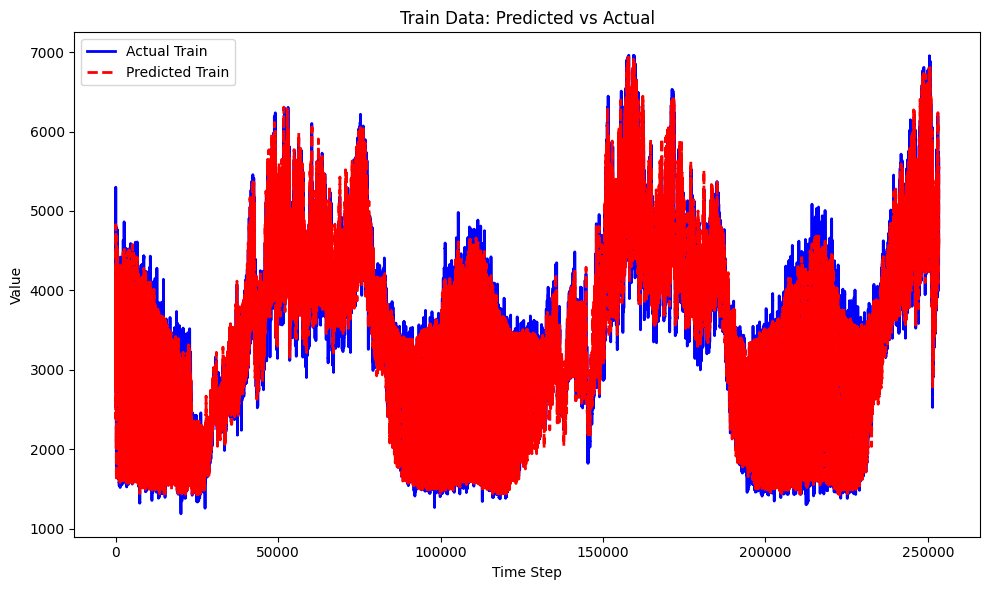

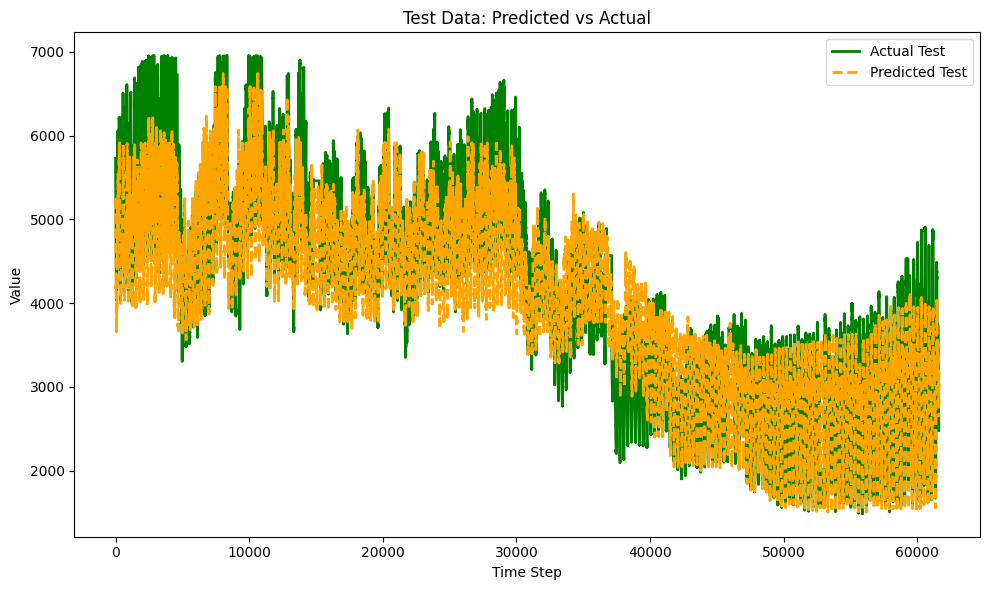

In [ ]:
import matplotlib.pyplot as plt

# Plot for training set
plt.figure(figsize=(10, 6))
plt.plot(train_actual, label='Actual Train', color='blue', linestyle='-', linewidth=2)
plt.plot(final_train_predictions_rescaled, label='Predicted Train', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Train Data: Predicted vs Actual')

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Plot for testing set
plt.figure(figsize=(10, 6))
plt.plot(test_actual, label='Actual Test', color='green', linestyle='-', linewidth=2)
plt.plot(final_test_predictions_rescaled, label='Predicted Test', color='orange', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Predicted vs Actual')

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()



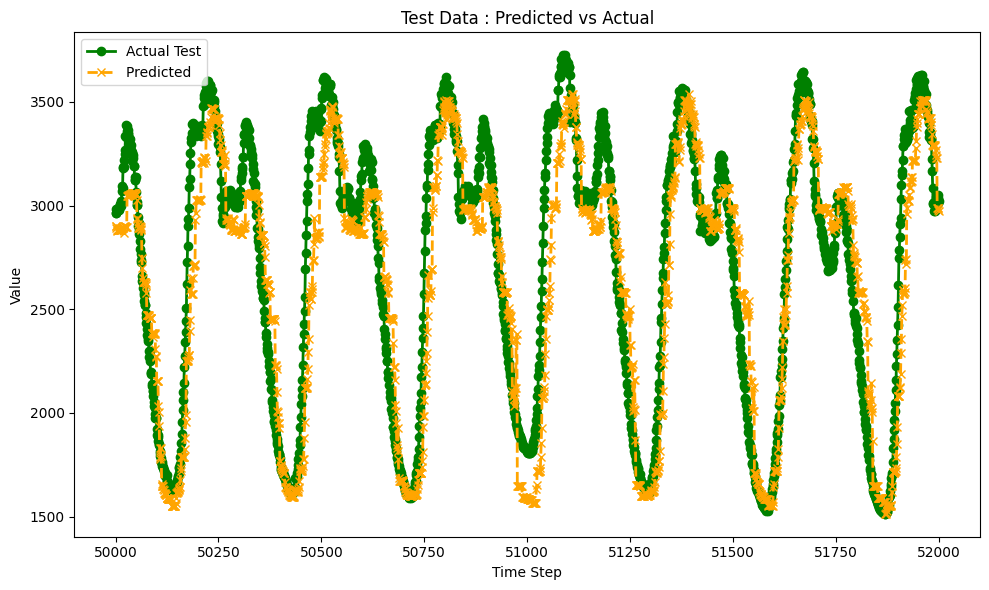

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of time steps you want to visualize (200 to 300)
start_step = 50000
end_step = 52000

# Extract the actual and predicted values within the specified range
test_actual_range = test_actual[start_step:end_step+1]  # +1 to include the end step
test_predictions_range = final_test_predictions_rescaled[start_step:end_step+1]

# Plot for testing set in the range 200-300
plt.figure(figsize=(10, 6))
plt.plot(range(start_step, end_step+1), test_actual_range, label='Actual Test' , color='green', marker='o', linestyle='-', linewidth=2)
plt.plot(range(start_step, end_step+1), test_predictions_range, label='Predicted ', color='orange', marker='x', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data : Predicted vs Actual')

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


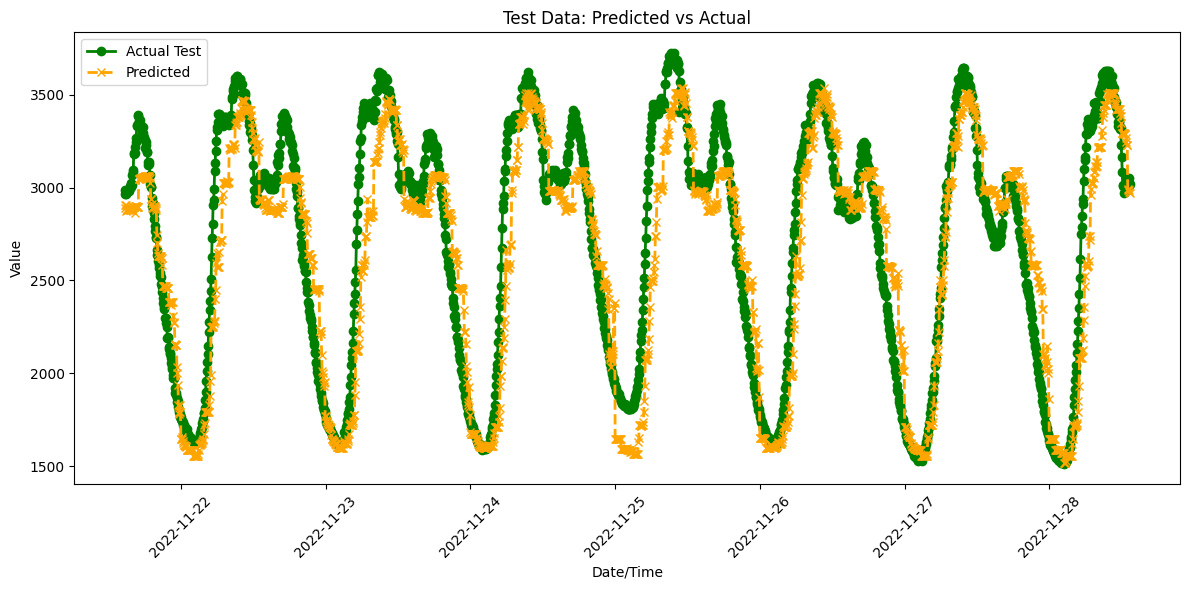

In [ ]:
import matplotlib.pyplot as plt

# Define the range of time steps you want to visualize (50000 to 52000)
start_step = 50000
end_step = 52000

# Extract actual and predicted values in the specified range
test_actual_range = test_actual[start_step:end_step + 1]
test_predictions_range = final_test_predictions_rescaled[start_step:end_step + 1]

# Extract the corresponding DateTime values for the time step range
dates = test_data['DateTime'].iloc[start_step:end_step + 1]

# Plot for the test set in the range 50000 to 52000
plt.figure(figsize=(12, 6))
plt.plot(dates, test_actual_range, label='Actual Test', color='green', marker='o', linestyle='-', linewidth=2)
plt.plot(dates, test_predictions_range, label='Predicted', color='orange', marker='x', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.title('Test Data: Predicted vs Actual')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

